<a href="https://colab.research.google.com/github/lucash-h/MNIST_Autoencoder/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [357]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Reshape, Flatten
from tensorflow.keras import layers, Model, losses
from tensorflow.keras.models import Sequential

from tqdm import tqdm

In [358]:
batch_size = 32
learning_rate = 0.001
epochs = 10
first_dim = 112
latent_dim = 64
shape = (28, 28, 1)

In [359]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [360]:
x_train = tf.reshape(x_train,(-1,batch_size,28,28,1))
print(x_train.shape)

(1875, 32, 28, 28, 1)


x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

In [361]:
def build_encoder(shape, first_dim, latent_dim):
    xin = Input(shape)
    xout = Flatten()(xin)
    xout = Dense(first_dim, activation='linear')(xout)
    xout = Dense(latent_dim, activation='relu')(xout)
    return Model(xin, xout)

In [362]:
def build_decoder(latent_dim, shape):
    xin = Input(shape=(latent_dim,))
    xout = Dense(tf.math.reduce_prod(shape), activation='sigmoid')(xin)
    xout = Reshape(shape)(xout)
    return Model(xin, xout)

In [363]:
encoder = build_encoder(shape, first_dim, latent_dim)
encoder.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 dense_63 (Dense)            (None, 112)               87920     
                                                                 
 dense_64 (Dense)            (None, 64)                7232      
                                                                 
Total params: 95152 (371.69 KB)
Trainable params: 95152 (371.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [364]:
decoder = build_decoder(latent_dim, shape)
decoder.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 64)]              0         
                                                                 
 dense_65 (Dense)            (None, 784)               50960     
                                                                 
 reshape_18 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
Total params: 50960 (199.06 KB)
Trainable params: 50960 (199.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [365]:
def build_autoencoder(encoder_model, decoder_model):

    encoder_input = encoder_model.input
    decoder_output = decoder_model(encoder_model.output)

    return Model(inputs=encoder_input, outputs=decoder_output)

In [366]:
autoencoder = build_autoencoder(encoder, decoder)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError()) # maybe change? good results with mean squared

In [367]:
ms_err = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [368]:
loss_log = {'loss':[]}

In [369]:
def train_step(sample):
  with tf.GradientTape() as tape:

    reconstructed_images = autoencoder(sample)

    autoencoder_loss = ms_err(sample, reconstructed_images)

    loss_log['loss'].append(autoencoder_loss)

  gradient = tape.gradient(autoencoder_loss, autoencoder.trainable_variables)
  optimizer.apply_gradients(zip(gradient,autoencoder.trainable_variables))
  return loss_log

In [370]:
#choose a random batch of 32
rand_index = np.random.randint(0,1875)
sample = x_train[rand_index]

print(sample.shape)

(32, 28, 28, 1)


In [371]:
#Train
for epoch in range(epochs):
  for batch in tqdm(sample):
    batch_loss = train_step(sample)

100%|██████████| 32/32 [00:00<00:00, 34.15it/s]


In [372]:
def show_images(num_images, images, title):
    num_cols = num_images

    fig, axes = plt.subplots(nrows=2, ncols=num_cols, figsize=(12, 6))
    plt.title(title)

    for i in range(num_images):
        axes[0, i].imshow(images[i][:, :, 0], cmap='gray')


In [373]:
def plot_img(n, real_img, real_img_label, fake_img, fake_img_title):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(real_img[i+n * 2])
    plt.title(real_img_label)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(fake_img[i+n * 2])
    plt.title(fake_img_title)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

1/1 [==============================] - 0s 64ms/step


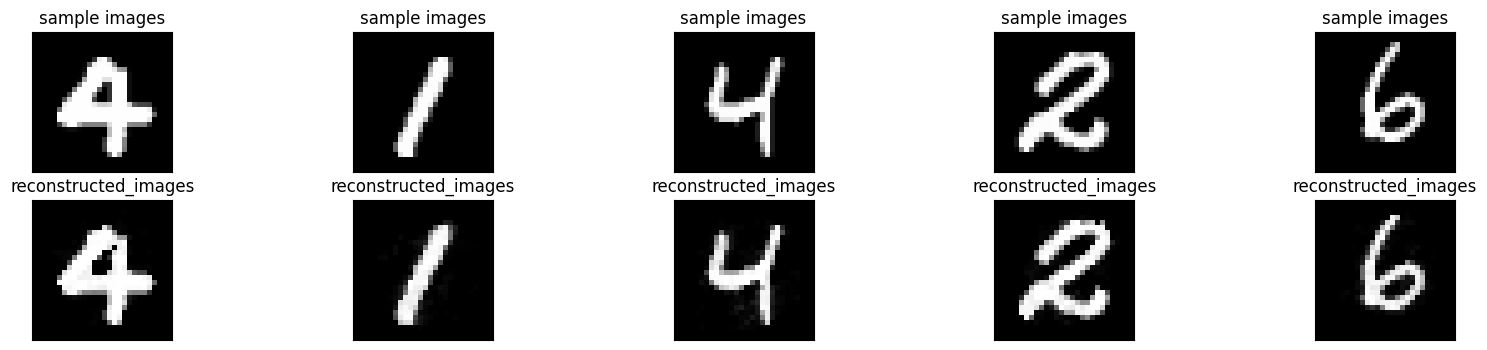

In [374]:
# Plot the first 5 images from x_train
reconstructed_images = autoencoder.predict(sample)

plot_img(5, sample, "sample images", reconstructed_images, "reconstructed_images")
